In [ ]:
!pip install wget glove-python3 navec slovnet -q

# Сравнение эмбеддеров

## Подготовка корпуса

Будем использовать библиотеку gensim. В ней есть много готового и полезного (конечно же на английском), но на русском тоже есть одна(!) модель. Не будем сейчас на этом зацикливаться, и попробуем всё-таки что-то готовое английское взять.

In [ ]:
import nltk
import numpy as np
from pymystem3 import Mystem
import gensim
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import gensim.downloader as api
corpus = api.load("fake-news")

In [ ]:
texts = []
for sent in corpus:
    texts.append(sent['title'] + ' ' + sent['text'])

In [ ]:
sentences = []
for sent in tqdm(texts):
    sentences.append([lemmatizer.lemmatize(word.lower()) for word in nltk.word_tokenize(sent) if word.isalpha()])

100%|██████████| 12999/12999 [01:59<00:00, 108.41it/s]


In [ ]:
sentences[0][:10]

['muslim',
 'busted',
 'they',
 'stole',
 'million',
 'in',
 'gov',
 't',
 'benefit',
 'print']

## Обучение моделей

В gensim есть готовые оболочки для Word2Vec и FastText, но нет Glove. Для неё есть отдельная библиотека с немного другим функционалом, но не страшно.

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
from glove import Glove, Corpus

In [ ]:
word2vec_skip = Word2Vec(sentences, vector_size=100, window=5, workers=4, sg=1, min_count=5)
fastText_skip = FastText(sentences, vector_size=100, window=5, workers=4, sg=1, min_count=5)

Для обучения Glove нужно создать объект модуля Corpus, который сам создаёт необходимый формат для обучения GLove. В основном, он автоматически подсчитывает матрицу встречаемости слов.

In [ ]:
all_words = set([word for sent in sentences for word in sent])
word2idx = {word: i for i, word in enumerate(all_words)}
idx2word = {i: word for word, i in word2idx.items()}

In [ ]:
corpus = Corpus(word2idx)
corpus.fit(sentences, window=5)

glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=20)
glove.add_dictionary(corpus.dictionary)

## Что они вообще умеют?
### Искать похожее

In [ ]:
word2vec_skip.wv.most_similar('say', topn=5)

[('said', 0.8067320585250854),
 ('tell', 0.7438023686408997),
 ('know', 0.7384950518608093),
 ('saying', 0.7351268529891968),
 ('believe', 0.726228654384613)]

In [ ]:
fastText_skip.wv.most_similar('say', topn=5)

[('said', 0.8293377161026001),
 ('sayin', 0.767259955406189),
 ('saying', 0.7430753111839294),
 ('sayng', 0.7231670618057251),
 ('know', 0.710961639881134)]

In [ ]:
glove.most_similar('say')

[('always', 0.991032088065335),
 ('never', 0.9871727117484671),
 ('before', 0.9863988778542605),
 ('should', 0.9860136667380589)]

Можно ли объяснить какие-то из полученных значений?

### Делать семантические пропорции

In [ ]:
word2vec_skip.wv.most_similar(positive=["girlfriend", "man"], negative=["woman"], topn=3)

[('quits', 0.6654525995254517),
 ('patrice', 0.6522437930107117),
 ('dj', 0.6478228569030762)]

In [ ]:
fastText_skip.wv.most_similar(positive=["girlfriend", "man"], negative=["woman"], topn=3)

[('boyfriend', 0.6798410415649414),
 ('kenny', 0.6784595847129822),
 ('rychner', 0.6774981617927551)]

GLove их делать не умеет, но мы умеем.

Функционал такой:
1. Складываем вектора тех слов, чьи значения хочется объединить
2. Вычитаем те слова, значения которых нам не нужны в итоговом слове
3. Усредняем
4. Ищем ближайший вектор к получившемуся с помощью косинусной близости

In [ ]:
# glove.word_vectors[:2]

In [ ]:
word_vec = (glove.word_vectors[glove.dictionary["girlfriend"]] + glove.word_vectors[glove.dictionary["man"]] - glove.word_vectors[glove.dictionary["woman"]]) / 3

In [ ]:
dst = (np.dot(glove.word_vectors, word_vec)
        / np.linalg.norm(glove.word_vectors, axis=1)
        / np.linalg.norm(word_vec))
word_ids = np.argsort(-dst)

[(glove.inverse_dictionary[x], dst[x]) for x in word_ids[:5] if x in glove.inverse_dictionary]

[('strongly', 0.9578082840559979),
 ('ante', 0.9570384462845664),
 ('supplement', 0.9570295601680127),
 ('legitimate', 0.9568222733448379),
 ('mysterious', 0.9554446256226715)]

### Выбирать лишнее

In [ ]:
word2vec_skip.wv.doesnt_match('man woman girl dog'.split())

'dog'

In [ ]:
fastText_skip.wv.doesnt_match('man woman girl dog'.split())

'dog'

Glove не умеет этого тоже:(

Но концепция такая же, смотрим попарные близости. Выбираем то слово, у которого со всеми остальными самая низкая близость.

### 3. Векторное пространство

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = ['cat', 'dog', 'frog', 'elephant', 'car', 'bicycle', 'bus', 'motorcycle']
X = word2vec_skip.wv[words]

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

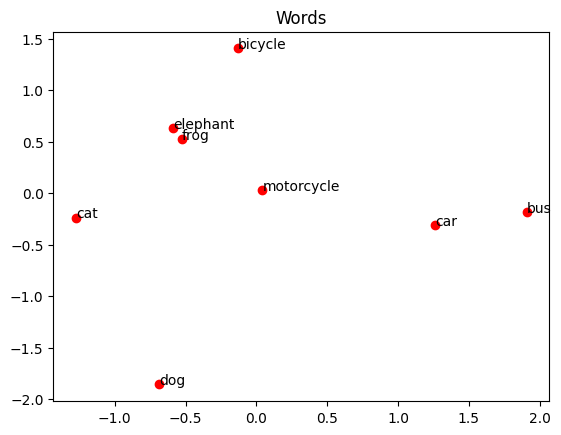

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

-----

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)[:10000]
    labels = np.asarray(model.wv.index_to_key)[:10000]  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 200)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

In [ ]:
x_vals, y_vals, labels = reduce_dimensions(word2vec_skip)

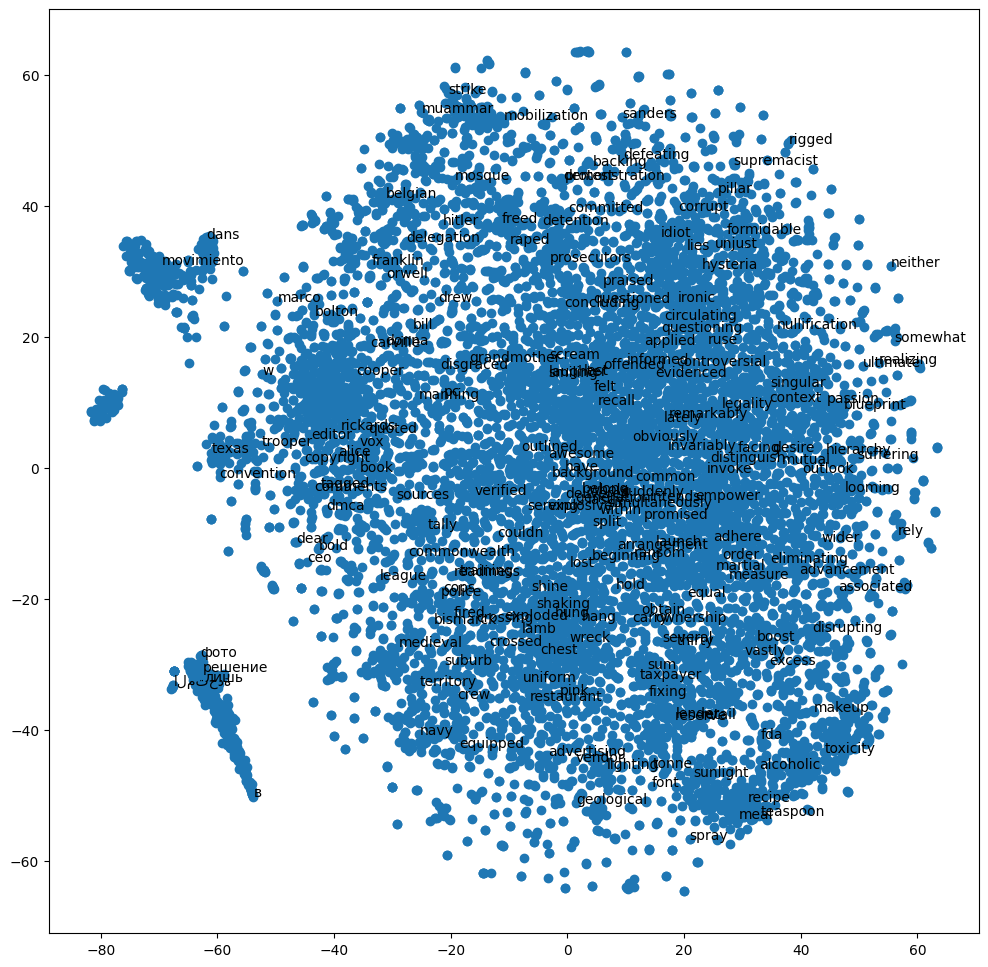

In [ ]:
plot_with_matplotlib(x_vals, y_vals, labels)

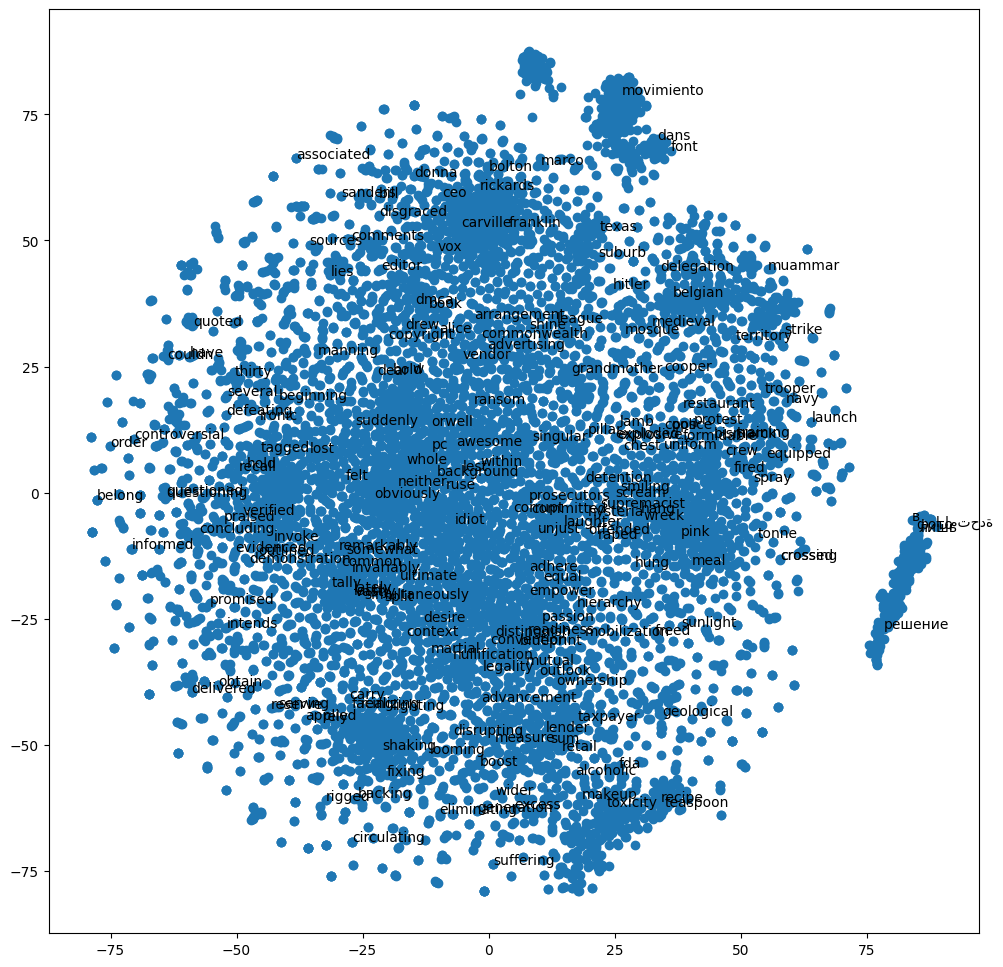

In [ ]:
x_vals, y_vals, labels = reduce_dimensions(fastText_skip)
plot_with_matplotlib(x_vals, y_vals, labels)

In [ ]:
def reduce_dimensions_glove(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.word_vectors)[:10000]
    labels = np.asarray(list(model.inverse_dictionary.values()))[:10000]  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
x_vals, y_vals, labels = reduce_dimensions_glove(glove)

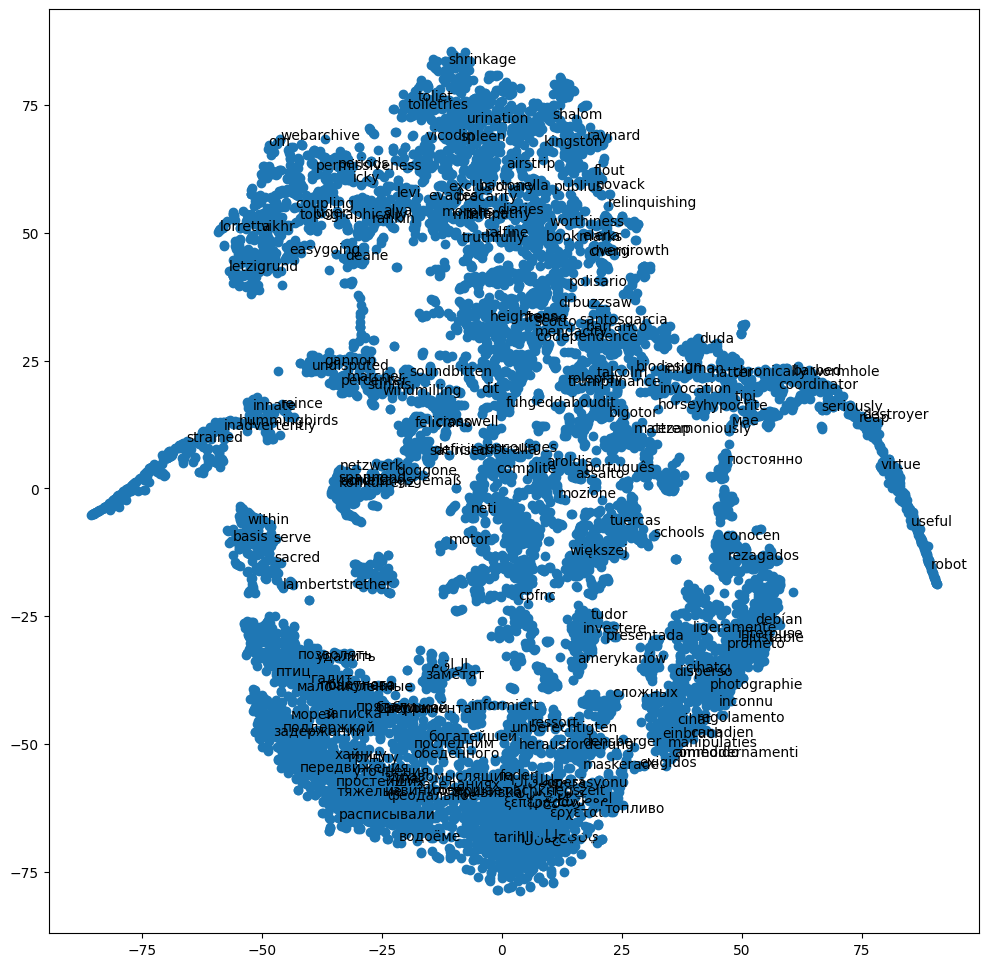

In [ ]:
plot_with_matplotlib(x_vals, y_vals, labels)

### Оценим работу эмбеддеров на размеченном датасете

In [ ]:
tqdm.pandas()
import pandas as pd
data = pd.read_csv('/content/wordsim353crowd.csv')

In [ ]:
data

,Word 1,Word 2,Human (Mean),w2v_pred,ft_pred
0,admission,ticket,0.55360,0.601939,0.638283
1,alcohol,chemistry,0.41250,0.682566,0.722630
2,aluminum,metal,0.66250,0.779060,0.819996
3,announcement,effort,0.20625,0.684351,0.677979
4,announcement,news,0.71875,0.738079,0.706062
...,...,...,...,...,...
348,weapon,secret,0.25000,0.700217,0.718857
349,weather,forecast,0.54375,0.760232,0.749561
350,Wednesday,news,0.11250,0.000000,0.717672
351,wood,forest,0.79375,0.746059,0.751385


In [ ]:
data['Human (Mean)'] = data['Human (Mean)'] / 10

In [ ]:
data.head()

,Word 1,Word 2,Human (Mean)
0,admission,ticket,0.55360
1,alcohol,chemistry,0.41250
2,aluminum,metal,0.66250
3,announcement,effort,0.20625
4,announcement,news,0.71875


In [ ]:
def get_prediction_gensim(model, word1, word2):
    try:
        return (model.wv.similarity(word1, word2) + 1) / 2
    except:
        return 0

data['w2v_pred'] = data.progress_apply(lambda row: get_prediction_gensim(word2vec_skip, row['Word 1'], row['Word 2']), axis=1)
data['ft_pred'] = data.progress_apply(lambda row: get_prediction_gensim(fastText_skip, row['Word 1'], row['Word 2']), axis=1)

100%|██████████| 353/353 [00:00<00:00, 11115.54it/s]


In [ ]:
from gensim import matutils
from numpy import dot
def get_prediction_glove(model, word1, word2):
    try:
        word1_vec = glove.word_vectors[glove.dictionary[word1.lower()]]
        word2_vec = glove.word_vectors[glove.dictionary[word2.lower()]]
        return (dot(matutils.unitvec(word1_vec), matutils.unitvec(word2_vec)) + 1) / 2
    except:
        return -1

data['glove_pred'] = data.progress_apply(lambda row: get_prediction_glove(glove, row['Word 1'], row['Word 2']), axis=1)

100%|██████████| 353/353 [00:00<00:00, 13572.06it/s]


In [ ]:
data.head()

,Word 1,Word 2,Human (Mean),w2v_pred,ft_pred,glove_pred
0,admission,ticket,0.55360,0.601939,0.638283,0.805282
1,alcohol,chemistry,0.41250,0.682566,0.722630,0.168926
2,aluminum,metal,0.66250,0.779060,0.819996,0.985928
3,announcement,effort,0.20625,0.684351,0.677979,0.930620
4,announcement,news,0.71875,0.738079,0.706062,0.949548


In [ ]:
# data = data[data['w2v_pred']!=0]

In [ ]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [ ]:
w2v_result = mse(data['Human (Mean)'], data['w2v_pred'])
ft_result = mse(data['Human (Mean)'], data['ft_pred'])
glove_result = mse(data['Human (Mean)'], data['glove_pred'])

In [ ]:
w2v_result, ft_result, glove_result

(0.14340068352185045, 0.13512595660636992, 0.18486830403963386)

## А что с ними делать ещё?

Использовать для решения различных задач. Если раньше вектор текста был например CountVectorizer или Tf-IDF, то сейчас можно документ представлять средним вектором всех его слов.
- Какие проблемы могут быть?

Следовательно, мы можем снова более хорошо, уже с дополнительными семантическими знаниями внутри векторов решать известные нам задачи:
- определение тематики текста
- тональности комментария
- языка текста


In [ ]:
text = 'This car is perfect for driving'
embs = word2vec_skip.wv[text.lower().split()]

In [ ]:
embs.shape

(6, 100)

In [ ]:
embs.mean(axis=0)

array([-0.04371371,  0.08030318,  0.05898372,  0.17393012,  0.02960617,
       -0.51308435,  0.2978458 ,  0.63112456, -0.24681626, -0.13389677,
        0.0395049 , -0.34582397,  0.12048853,  0.20514877,  0.30116335,
       -0.06482089,  0.13362634, -0.27322006, -0.21843922, -0.42883456,
        0.20616277, -0.00690091,  0.17823033,  0.05211826, -0.11202174,
        0.03807834, -0.20164047,  0.22897899,  0.12907758,  0.00764659,
        0.3062913 , -0.12484749,  0.22216915, -0.12028059, -0.03368611,
        0.21458161,  0.01592749,  0.11159406, -0.09622046, -0.06404233,
        0.24988894, -0.172696  ,  0.12820126, -0.00231764,  0.09392524,
       -0.05464058, -0.07330387,  0.07045876,  0.15139467,  0.13184415,
       -0.12297577, -0.14043611, -0.01529441,  0.10918025,  0.07225559,
       -0.06511088,  0.27480265, -0.1007357 , -0.00122766, -0.05548893,
        0.08822715, -0.17829607,  0.20411731, -0.03582441, -0.16070229,
        0.23323911,  0.04301847,  0.2638394 , -0.12963557,  0.06